sell


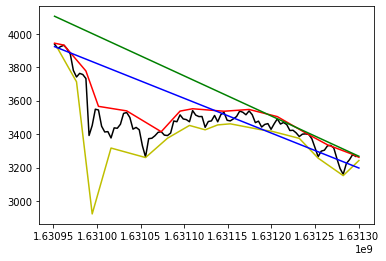

In [1]:
from mine import trend_utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import date_utils
import ccxt

df1 = pd.read_csv('data/20200101-ETH_future.csv')
binance = ccxt.binance()
eth = binance.fetch_ticker("ETH/USDT")

a = trend_utils.trend(df1[len(df1)-34:len(df1)].reset_index(drop=True))
print(a.near_trend(eth['close']))
a.graph(df1)



In [ ]:
from mine import market, trend_utils
import asyncio
import nest_asyncio
import time
from datetime import datetime, timezone
import pandas as pd
from utils import ccxt_utils, cq_utils   
import pickle

nest_asyncio.apply()

BINANCE_SYMBOL = 'ETH/USDT'


async def hour():
    global trend
    global data
    print('hour')
    since = data['datetime'][len(data)-1]
    since_timestamp = binance.parse8601(since)
    
    data_1h = ccxt_utils.fetch_ohlcv(BINANCE_SYMBOL, binance, timeframe='1h', start=since, end=None)
    data_1h_df = ccxt_utils.ohlcv_to_df(data_1h['data'])
    data_1h_df.to_csv('data/temp.csv')
    
    data_1h_df=pd.read_csv('data/temp.csv').reset_index(drop=True)
    data=data.reset_index(drop=True)
    total=pd.concat([data, data_1h_df[1:]], ignore_index=True)

    d=total[len(data)-80:len(data)].reset_index(drop=True)
    trend=trend_utils.trend(d)
    data=total
    total=total.set_index('datetime',append=False)
    total.to_csv('data/20200101-ETH.csv')
    await asyncio.sleep(3600)
    
    
async def minute():
    print('minute')
    global data
    global trend
    global temp_position
    
    log=[]
    d=data[len(data)-80:len(data)]
    temp_price= binance.fetch_ticker('ETH/USDT')['close']
    position=trend.near_trend(temp_price)
    if position == 'buy' and not temp_position=='buy':
        
        if market.get_USDTbalance()>=10:
            order = binance.create_market_buy_order('ETH/USDT', market.get_USDTbalance())
        
        log.append([time.ctime(), 'buy', '-'])
        temp_position='buy'
        record=pd.DataFrame(log)
        record.to_csv("./data/trading.csv", mode='a')
    elif position == 'sell' and not temp_position=='sell':
        
        if market.get_USDTbalance()<10:
            order = binance.create_market_sell_order('ETH/USDT', market.get_ETHbalance())
        
        log.append([time.ctime(), 'sell', market.get_USDTbalance()])
        temp_position='sell'
        record=pd.DataFrame(log)
        record.to_csv("./data/trading.csv", mode='a')
    
    await asyncio.sleep(60)

async def min_loop():
    while True:
        await minute()
async def hour_loop():
    while True:
        await hour()

async def main():
    global data
    global trend
    global temp_position
    await asyncio.gather(min_loop(), hour_loop())

data=pd.read_csv('data/20200101-ETH.csv').reset_index(drop=True)
trend=trend_utils.trend(data[len(data)-80:len(data)].reset_index(drop=True))
temp_position='start'

loop=asyncio.get_event_loop()
try:
    loop.run_until_complete(main())  
except KeyboardInterrupt:
    print('end')
loop.close()


In [ ]:
#data fetching
from utils import ccxt_utils
import ccxt
from mine import market

binance= ccxt.binance({
    'options': {
        'adjustForTimeDifference': True,
        'defaultType': 'future'
    },
    'rateLimit': 10000,
    'enableRateLimit': True,
    # 'verbose': True,
    'apiKey': 'BpLnIGqKodX0EXAxuR14cpbYax4T6Z1KvrQ8Xbevk3PdmcMjO3J06UK9g6IDS1eG',
    'secret': '90uKFUV4b0HBjOLtmQmSsHdv9rrYGcZlufEwfrnryAfHzT2BB3Xck5ufsfQXnfW9',
})

since = '2020-01-01 00:00:00'
since_timestamp = binance.parse8601(since)
print(since_timestamp)
BINANCE_SYMBOL='ETH/USDT'
'''
data_1h = ccxt_utils.fetch_ohlcv(BINANCE_SYMBOL, binance_futures, timeframe='1h', start=since, end=None)
data_1h_df = ccxt_utils.ohlcv_to_df(data_1h['data'])
data_1h_df.to_csv('data/20200101-ETH_futures.csv')
'''
order = binance.create_market_sell_order('ETH/USDT', market.get_ETHbalance_future())

In [5]:
#test
from mine import trend_utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import date_utils
import ccxt

df1 = pd.read_csv('data/20200101-ETH_future.csv')

columns=['datetime', 'buy/sell', 'profit']
temp='none'
temp_price=df1['open'][0]
total_profit=500000
data=[]
buy_price=0
sell_price=0
for i in range(35, len(df1)):
    d=df1[i-34:i].reset_index(drop=True)
    a=trend_utils.trend(d)
    temp_price=df1['close'][i-1]
    position=a.near_trend(temp_price, df1['datetime'][i-1])
    
    if buy_price>0 and temp_price<=buy_price*0.80:
        print("청산")
        total_profit=0
    if sell_price>0 and temp_price>=sell_price*1.20:
        print("청산")
        total_profit=0
    if position == 'buy' and temp=='none':
        buy_price=df1['close'][i-1]
        data.append([df1['datetime'][i-1], 'buy', '-'])
        temp='buy'
    elif position == 'sell' and temp=='none':
        sell_price=df1['high'][i-1]
        data.append([df1['datetime'][i-1], 'sell', '-'])
        temp='sell'
    elif position == 'buy' and temp=='sell':
        buy_price=df1['close'][i-1]
        total_profit=total_profit*(sell_price/df1['low'][i-1]*5-4)*0.99
        sell_price=0
        data.append([df1['datetime'][i-1], 'buy', '-'])
        temp='buy'
    elif position == 'sell' and temp=='buy':
        sell_price=df1['close'][i-1]
        total_profit=total_profit*(df1['high'][i-1]/buy_price*5-4)*0.99
        buy_price=0
        data.append([df1['datetime'][i-1], 'sell', '-'])
        temp='sell'
    elif position == 'none' and temp=='sell':
        temp='none'
        total_profit=total_profit*(sell_price/df1['low'][i-1]*5-4)*0.99
        data.append([df1['datetime'][i-1], 'none', total_profit])
        sell_price=0
    elif position == 'none' and temp=='buy':
        temp='none'
        total_profit=total_profit*(df1['high'][i-1]/buy_price*5-4)*0.99
        data.append([df1['datetime'][i-1], 'none', total_profit])
        buy_price=0
data.append(['total', '',total_profit])
record=pd.DataFrame(data, columns=columns)
record.to_csv("./data/test.csv", mode='a')
    

In [ ]:
#최적화

from mine import market, trend_utils
import pandas
from mine import trend_utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import date_utils
import ccxt

df1 = pd.read_csv('data/20200101-ETH_future.csv')
columns=['size', 'profit']
temp_price=df1['open'][0]
data=[]
size=50
while size >10:
    total_profit=100
    buy_price=0
    sell_price=0
    temp='none'
    for i in range(size+1, len(df1)):
        d=df1.iloc[i-size:i].reset_index(drop=True)
        a=trend_utils.trend(d,size)
        position=a.near_trend(df1['close'][i-1])
    
        if position == 'buy' and temp=='none':
            buy_price=df1['close'][i-1]
            temp='buy'
        elif position == 'sell' and temp=='none':
            sell_price=df1['high'][i-1]
            temp='sell'
        elif position == 'buy' and temp=='sell':
            buy_price=df1['close'][i-1]
            total_profit=total_profit*(sell_price/df1['low'][i-1]*3-2)*0.99
            temp='buy'
        elif position == 'sell' and temp=='buy':
            sell_price=df1['high'][i-1]
            total_profit=total_profit*(df1['high'][i-1]/buy_price*3-2)*0.99
            temp='sell'
        elif position == 'none' and temp=='sell':
            temp='none'
            total_profit=total_profit*(sell_price/df1['low'][i-1]*3-2)*0.99
            sell_price=0
        elif position == 'none' and temp=='buy':
            temp='none'
            total_profit=total_profit*(df1['high'][i-1]/buy_price*3-2)*0.99
            buy_price=0
    data=[size, total_profit]
    print(data)
    record=pd.DataFrame([data], columns=columns)
    record.to_csv("./data/test.csv", mode='a')
    size-=1
